In [1]:
%matplotlib inline

import os
import sys
import copy
import random
import tqdm.notebook as tq

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.utils
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.transforms.functional as TF

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device =',device)

device = cuda:0


# Load Data

In [2]:
# Initial files are in 'input' directory
img_dir = 'input/train_images_256'
mask_dir = 'input/train_masks_256'

# Get all filenames in folder: 
img_files = [os.path.join(path, name) for path, subdirs, files in os.walk(img_dir) for name in files]

msk_files = [os.path.join(path, name) for path, subdirs, files in os.walk(mask_dir) for name in files]

print('Image files: ', len(img_files))
print('First 5 file names:', img_files[0:5])
print()
print('Mask files: ', len(msk_files))
print('First 5 file names:', msk_files[0:5])

Image files:  790
First 5 file names: ['input/train_images_256/041869.000023.tif', 'input/train_images_256/041874.000046.tif', 'input/train_images_256/045590.000176.tif', 'input/train_images_256/045594.000047.tif', 'input/train_images_256/041874.000063.tif']

Mask files:  790
First 5 file names: ['input/train_masks_256/041869.000023.tif', 'input/train_masks_256/041874.000046.tif', 'input/train_masks_256/045590.000176.tif', 'input/train_masks_256/045594.000047.tif', 'input/train_masks_256/041874.000063.tif']


In [3]:
def image_properties(img):
    '''
    Print image file properties
    '''
    print('image type:', type(img))
    print('image mode:', img.mode)
    print('image info:', img.info)
    array = np.array(img)
    print('image shape:', array.shape)
    print('min:', array.min(),'std:', array.std(),'mean:', array.mean(), 'max:',  array.max())
    print('array:', array)

def preview(images):
    '''
    Preview images stacked horizontally
    '''
    fig, axs = plt.subplots(1, len(images), figsize=(10,10))
    for i, image in enumerate(images):
        axs[i].imshow(image)
        axs[i].axis('off')
    plt.show()

image:
image type: <class 'PIL.TiffImagePlugin.TiffImageFile'>
image mode: I;16
image info: {'compression': 'raw', 'dpi': (1, 1), 'resolution': (1, 1)}
image shape: (256, 256)
min: 8499 std: 4967.71548363524 mean: 26219.83383178711 max: 54887
array: [[25850 39660 35057 ... 27621 21955 22309]
 [32578 35057 28329 ... 15227 19476 26204]
 [43201 31516 33640 ... 12748 19476 22663]
 ...
 [31870 24788 26558 ... 29391 21247 25142]
 [25142 23017 25496 ... 26204 24434 24079]
 [31516 26204 24079 ... 15581 27266 27621]]

mask: 
image type: <class 'PIL.TiffImagePlugin.TiffImageFile'>
image mode: L
image info: {'compression': 'raw', 'dpi': (1, 1), 'resolution': (1, 1)}
image shape: (256, 256)
min: 0 std: 0.10272401750228878 mean: 0.00823974609375 max: 2
array: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


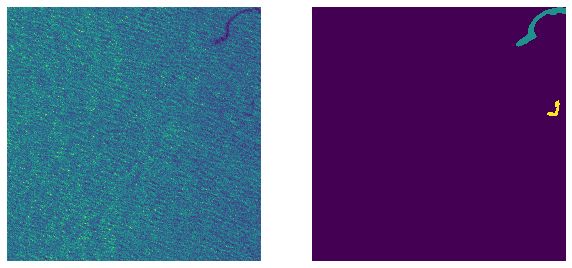

In [4]:
# image file
print('image:')
img = Image.open(img_files[0])
image_properties(img)
# I;16 mode = 16-bit unsigned integer pixels
print()
print('mask: ')
# mask file
msk = Image.open(msk_files[0])
image_properties(msk)
# L mode = 8-bit pixels, black and white
preview((img, msk))

## Image Transform Fuctions

(256, 256)
(256, 256)
(7, 256, 256)
(256, 256)


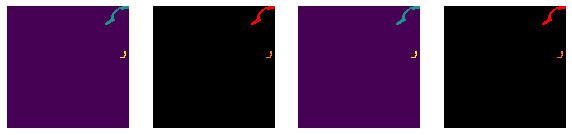

In [6]:
# We need to convert L to P(palette mode) to view the mask images nicely 
def palette():
    '''
    Returns palette (used in 'P' mode of image representation)
    '''
    colors_dict = {
        0: [0, 0, 0],       # 0 = background: black
        1: [255, 0, 0],     # 1 = seep class 1: red
        2: [255, 127, 0],   # 2: orange 
        3: [255, 255, 0],   # 3: yellow
        4: [0, 255, 0],     # 4: green
        5: [0, 0, 255],     # 5: blue
        6: [46, 43, 95],    # 6: dark blue
        7: [139, 0, 255],   # 7: purple
        }
    palette = []
    for i in np.arange(256):
        if i in colors_dict:
            palette.extend(colors_dict[i])
        else:
            palette.extend([0, 0, 0])
    return palette

def mask2p(msk):
    """
    Converts mask to P-mode image
    """
    msk=msk.convert('P')
    msk.putpalette(palette())
    return msk

def mask2onehot(mask):
    """
    Converts a segmentation mask (H,W) to (C,H,W) where the 0 dim is a C-one-hot encoding vector
    Where K - number of classes
    """
    classes = [1,2,3,4,5,6,7] # Classes in the dataset
    mask = np.asanyarray(mask)
        
    _mask = [mask == i for i in classes]
    mask = np.array(_mask).astype(np.uint8)
      
    #mask = np.where(mask == 0, 0, 1).astype(np.uint8) # for 1 channel only
    return mask

def onehot2mask(onehot):
    """
    Converts onehot representation (C, H, W) to mask representation (H,W)
    """
    zeros = np.zeros_like(onehot[0,:,:])
    zeros = np.expand_dims(zeros, axis=0)
    onehot = np.concatenate((zeros, onehot), axis=0)    
    array = np.argmax(onehot, axis=0).astype(np.uint8)
    
    #array = onehot.astype(np.uint8) # for 1 channel

    return Image.fromarray(array, 'L')

def onehot2p(onehot):
    """
    Converts onehot representation (C, H, W) to P image mask representation (H,W)
    """
    mask = onehot2mask(onehot)
    maskp = mask2p(mask)
    return maskp

## Check that conversions work fine
msk = msk_files[0]
msk = Image.open(msk)
print(msk.size)

mskp = mask2p(msk)
print(mskp.size)

onehot = mask2onehot(msk)
print(onehot.shape)

mskinv = onehot2mask(onehot)
mskinv.size

mskpp = onehot2p(onehot)
print(mskpp.size)

preview((msk, mskp, mskinv, mskpp))

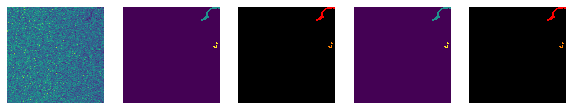

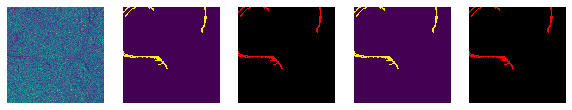

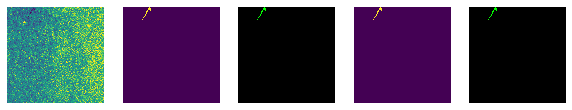

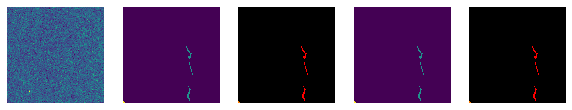

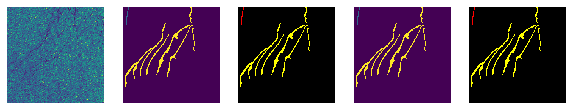

In [7]:
# Check conversions, preview some images
n_preview = 5
for i in range(n_preview):
    img = img_files[i]
    msk = msk_files[i]
    img = Image.open(img)
    msk = Image.open(msk)
    mskp = mask2p(msk)
    onehot = mask2onehot(msk)
    #preview((msk, mskp, onehot))
    
    invonehot = onehot2mask(onehot)
    invonehotp = onehot2p(onehot)
    preview((img, msk, mskp, invonehot, invonehotp))

# Train/Test Split

In [8]:
from sklearn.model_selection import train_test_split

imgs_train, imgs_val, msks_train, msks_val = \
    train_test_split(img_files, msk_files, test_size=0.2, shuffle=True, random_state=42)
print(len(imgs_train), len(imgs_val))

632 158


In [9]:
def class_distribution(filenames, show=False):
    all = []
    for msk in filenames:
        msk = Image.open(msk)
        array = np.array(msk)
        all.append(array)
    all = np.array(all)
    all.flatten()
    counts = np.unique(all, return_counts = True)
    print('classes:', counts[0])
    print('counts:', counts[1])
    if show:
        plt.bar(counts[0][1:], counts[1][1:]) # dont show class 0 - background
        plt.show()

classes: [0 1 2 3 4 5 6 7]
counts: [40675049   420920    54244    18617    35771   121260    86464     6427]


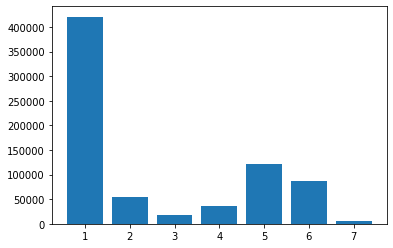

classes: [0 1 2 3 4 5 6 7]
counts: [40675049   420920    54244    18617    35771   121260    86464     6427]


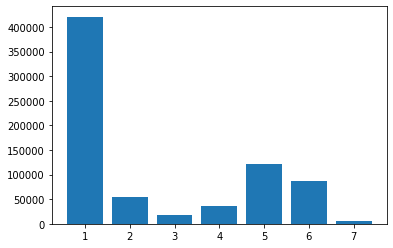

classes: [0 1 2 3 4 5 6 7]
counts: [10163439   104415    10514     3872     7186    33931    29765     1566]


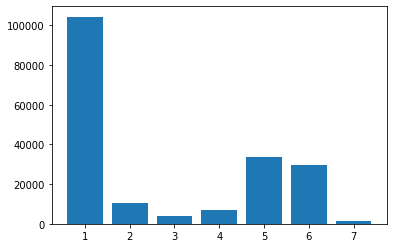

In [10]:
class_distribution(msks_train, show=True)
# The problem is quite imbalanced with class 1 - 65 times more represented then class 7

class_distribution(msks_train, show=True)
class_distribution(msks_val, show=True)
# Val set distribution is slightly different from train test split - possibly needs improvement 

# Make Dataset

In [11]:
# Images need to be normalized , let's find normalization parameters:
lst = []
for image in imgs_train:
    image = Image.open(image)
    array = np.array(image)
    lst.append(array)
MU = np.mean(lst)
STD = np.std(lst)    
print('mean:', MU, 'std:', STD, 'min:', np.min(lst), 'max:', np.max(lst))

mean: 28974.71406021601 std: 10697.437589236108 min: 0 max: 65535


In [12]:
def normalize(im):
    """
    Normalize numpy array using MU and STD
    """
    im = np.array(im)
    im = (im - MU)/STD
    return im

def inv_normalize(im):
    """
    Inverse normalize numpy array using MU and STD
    Returns: Image
    """
    #im = im.numpy()
    im = np.squeeze(im)
    im = im * STD + MU
    im = im.astype('uint16')
    im = Image.fromarray(im, 'I;16')
    return im

In [16]:
class MyDataset(Dataset):
    def __init__(self, image_paths, target_paths, augment):
        self.image_paths = image_paths
        self.target_paths = target_paths
        self.augment = augment

    def transform(self, image, mask, augment):
        if augment:
            # Random rotate
            rotate = transforms.RandomRotation(180)
            angle = rotate.get_params(rotate.degrees)
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle)

            # Random horizontal flipping
            if random.random() > 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)

        image = normalize(image)
        image = TF.to_tensor(image)
        
        mask = mask2onehot(mask)
        mask = torch.tensor(mask, dtype=torch.uint8)
        mask = torch.unsqueeze(mask,0)
        
        #mask = TF.to_tensor(mask)        
        #mask = mask.permute(1, 2, 0) #mul channel
        return image, mask

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        mask = Image.open(self.target_paths[index])
        x, y = self.transform(image, mask, augment=self.augment)
        return x, y

    def __len__(self):
        return len(self.image_paths)

# Instantiate Datasets
train_dataset = MyDataset(imgs_train, msks_train, augment=True)
val_dataset = MyDataset(imgs_val, msks_val, augment=False)

In [17]:
# Check Dataloaders
iterator_train = iter(train_dataset)
iterator_val = iter(val_dataset)

image:
<class 'torch.Tensor'> torch.Size([1, 256, 256])
-2.7085658428492 2.589805802434443 1.0910915247326844 -0.2717585813007296
image shape: (256, 256)
mask:
<class 'torch.Tensor'> torch.Size([1, 7, 256, 256])
onehot shape: (1, 7, 256, 256)
onehot squeeze: (7, 256, 256)
0 1 0.024565168276311056 0.0006038120814732143


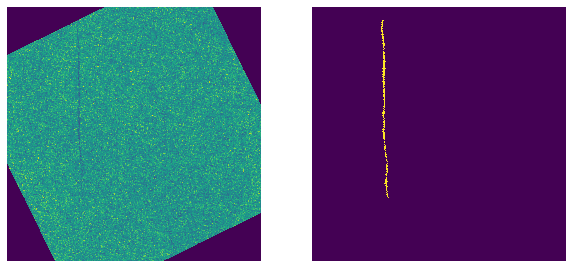

In [19]:
# Preview from dataloader
image, onehot = next(iterator_train)

print('image:')
print(type(image), image.shape)

image = image.numpy()
print(image.min(), image.max(), image.std(), image.mean())
image = np.squeeze(image)
print('image shape:', image.shape)
image = inv_normalize(image)

print('mask:')
print(type(onehot), onehot.shape)
onehot = onehot.numpy()
print('onehot shape:', onehot.shape)
onehot = np.squeeze(onehot)
print('onehot squeeze:', onehot.shape)

print(onehot.min(), onehot.max(), onehot.std(), onehot.mean())
mask = onehot2mask(onehot)
preview((image, mask))

In [20]:
# Create Dataloaders
BATCH_SIZE = 16
dataloader_train = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print('n_batches_train:', len(dataloader_train), 'n_batches_val:', len(dataloader_val))

n_batches_train: 40 n_batches_val: 10


## Model

In [22]:
from segmentation_models import UNet
model = UNet(7, 1)
model=model.to(device)
summary(model, input_size=(1, 256, 256)) # input size required to do the forward pass throught the model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             640
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

## Loss

In [23]:
from segmentation_loss import BCELoss, DiceLoss, DiceBCELoss, FocalTverskyLoss

## Train Function

In [24]:
def train(model, optimizer, scheduler, loss_fn, num_epochs=1):
    
    # init Loss functions used to track performance
    dice_loss = DiceLoss()
    bce_loss = BCELoss() # only bce for 
    
    #Check device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('device =',device)
    model=model.to(device)

    # Instantiate SummaryWriter
    writer = SummaryWriter()
    
    #Initialize some variables
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    lr = 0 #required so that learning rate prints first time   
    
    total_train_samples = 0
    total_test_samples = 0   
    
    # Iterate over epochs
    for epoch in tq.tqdm(range(num_epochs)):

        # print learning rate if it was changed in this epoch
        if lr != optimizer.param_groups[0]['lr']:
            lr = optimizer.param_groups[0]['lr']
            print('learning rate =', lr)
        
        #Train      
        model.train()
        torch.set_grad_enabled(True)
       
        for imgs, msks in dataloader_train:
            
            imgs = imgs.to(device, dtype=torch.float32)    
            msks = msks.to(device, dtype=torch.float32)
            
            batch_size = imgs.size(0)
            total_train_samples += batch_size

            optimizer.zero_grad()
            msks_pred = model(imgs)            
  
            loss = loss_fn(msks_pred, msks)
            
            writer.add_scalar('train_loss', loss, total_train_samples)
            
            loss.backward()            
            optimizer.step()       
        
       
        #Eval        
        if epoch % 1 == 0: # evaluate results for epochs ## n , e.g: 0, 10, 20...
            
            model.eval()
            torch.set_grad_enabled(False)
            
            epoch_bce_loss = 0
            epoch_dice_loss = 0           
            epoch_loss = 0            
            
            for imgs, msks in dataloader_val:
                
                imgs = imgs.to(device, dtype=torch.float32)
                msks = msks.to(device, dtype=torch.float32)
                
                batch_size = imgs.size(0)
                total_test_samples+=batch_size

                msks_pred = model(imgs)             
                loss = loss_fn(msks_pred, msks)
                
                writer.add_scalar('val_loss', loss, total_test_samples)                 
                
                epoch_dice_loss += dice_loss(msks_pred, msks)
                epoch_bce_loss += bce_loss(msks_pred, msks)
                epoch_loss += loss
            
            #Save best model
            save = ''
            if epoch_loss < best_loss:
                save = 'model saved'
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'current_best_model_state_dict.pth')
                
            print('epoch:', epoch,
                  'bce:', round(epoch_bce_loss.item(), 3),
                  'dice:', round(epoch_dice_loss.item(), 3),
                  'loss:', round(epoch_loss.item(), 3),  
                  save)
       
        #Step for learning rate scheduler
        scheduler.step()
    
    # Close SummaryWriter
    writer.close()
    
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

## Initialize Model Weights

In [30]:
# UNET
# https://discuss.pytorch.org/t/how-are-layer-weights-and-biases-initialized-by-default/13073/24
# https://pytorch.org/docs/stable/nn.init.html
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        #torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        torch.nn.init.zeros_(m.bias)

model=model.to(device)

model.apply(weights_init)
#model.load_state_dict(torch.load('current_best_model_state_dict.pth', map_location=torch.device('cpu')))
print()

## Train

In [39]:
%%time

#%load_ext tensorboard
# !rm -rf runs # clean any previous data from tensorboard
#%tensorboard --logdir runs --host=127.0.0.1

optimizer = optim.Adam(model.parameters(), lr=3e-5)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

#loss = DiceLoss()
#loss = DiceBCELoss(bce_weight=0.01)
loss = FocalTverskyLoss(alpha = 0.7, beta = 0.3, gamma = 1.33)

model=train(model=model, optimizer=optimizer, scheduler=exp_lr_scheduler, loss_fn=loss,  num_epochs=10)

device = cuda:0


learning rate = 3e-05
epoch: 0 bce: 0.499 dice: 6.532 loss: 5.602 model saved
epoch: 1 bce: 0.476 dice: 7.23 loss: 5.653 
epoch: 2 bce: 0.461 dice: 6.607 loss: 5.15 model saved
epoch: 3 bce: 0.532 dice: 6.572 loss: 5.239 
epoch: 4 bce: 0.487 dice: 6.563 loss: 5.223 
epoch: 5 bce: 0.542 dice: 6.459 loss: 5.224 
epoch: 6 bce: 0.467 dice: 6.298 loss: 5.136 model saved
epoch: 7 bce: 0.464 dice: 6.581 loss: 5.085 model saved
epoch: 8 bce: 0.459 dice: 6.425 loss: 4.964 model saved
epoch: 9 bce: 0.428 dice: 6.279 loss: 5.147 

Best val loss: 4.964086
CPU times: user 15min 30s, sys: 3min 55s, total: 19min 25s
Wall time: 16min 7s


In [35]:
#torch.save(model.state_dict(), 'model_state_dict.pth')

## Preview Results

In [36]:
def distr(msk):
    array = np.array(msk)
    counts = np.unique(array, return_counts = True)
    print('classes:', counts[0])
    print('counts:', counts[1])

mask:
classes: [0 5]
counts: [65315   221]
pred:
classes: [0]
counts: [65536]


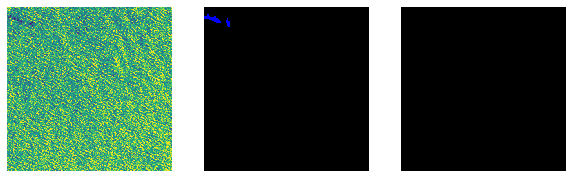

mask:
classes: [0 5]
counts: [64901   635]
pred:
classes: [0]
counts: [65536]


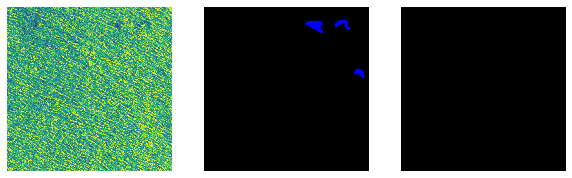

mask:
classes: [0 1]
counts: [65404   132]
pred:
classes: [0 1]
counts: [65079   457]


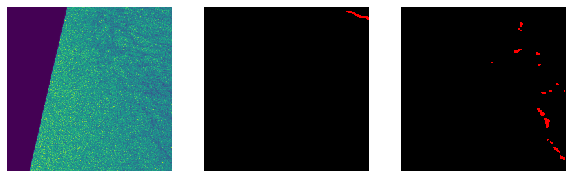

mask:
classes: [0 4]
counts: [64436  1100]
pred:
classes: [0]
counts: [65536]


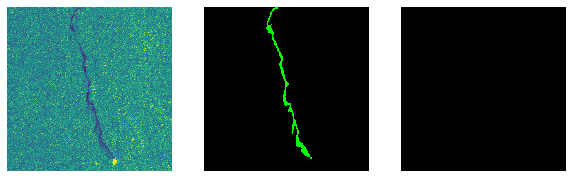

mask:
classes: [0 1]
counts: [64353  1183]
pred:
classes: [0 1]
counts: [64797   739]


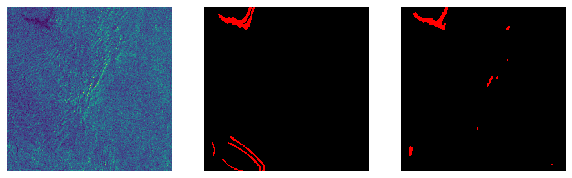

mask:
classes: [0 4 5]
counts: [64942   241   353]
pred:
classes: [0 1]
counts: [65227   309]


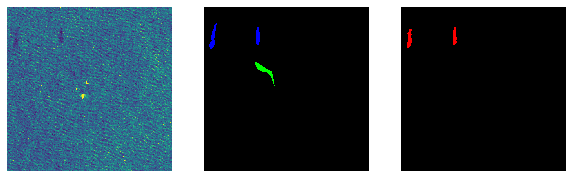

mask:
classes: [0 1]
counts: [65328   208]
pred:
classes: [0 1]
counts: [65280   256]


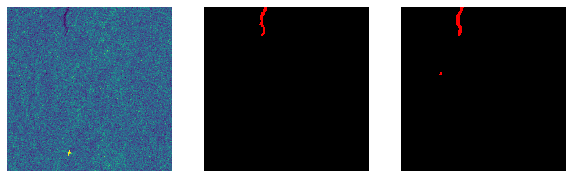

mask:
classes: [0 1 6]
counts: [64105   558   873]
pred:
classes: [0 1]
counts: [63485  2051]


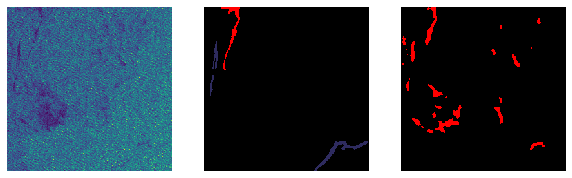

mask:
classes: [0 1 4 5 6]
counts: [62893  1601   502   460    80]
pred:
classes: [0 1]
counts: [63808  1728]


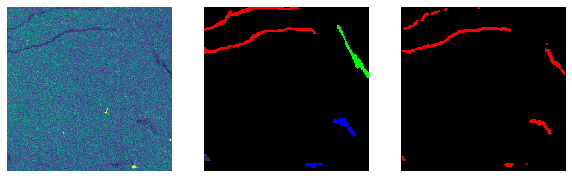

mask:
classes: [0 1]
counts: [64695   841]
pred:
classes: [0 1]
counts: [64958   578]


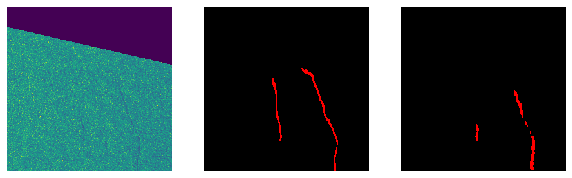

mask:
classes: [0 4 5]
counts: [64841   508   187]
pred:
classes: [0]
counts: [65536]


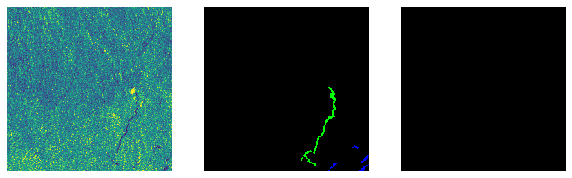

mask:
classes: [0 1 2]
counts: [64915   533    88]
pred:
classes: [0 1]
counts: [65101   435]


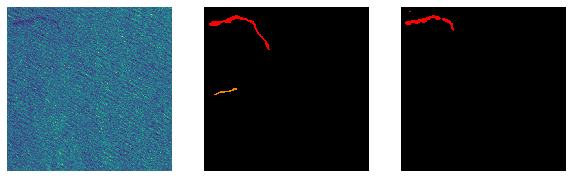

mask:
classes: [0 1 3]
counts: [65180   329    27]
pred:
classes: [0 1]
counts: [65519    17]


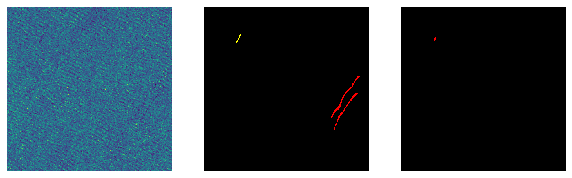

mask:
classes: [0 1 3]
counts: [65222   303    11]
pred:
classes: [0 1]
counts: [65269   267]


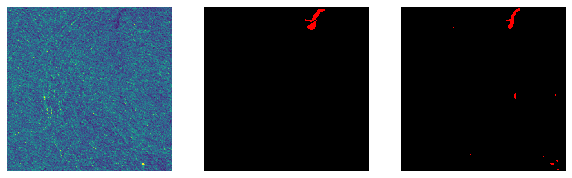

mask:
classes: [0 1 6 7]
counts: [62204  3111   185    36]
pred:
classes: [0 1]
counts: [63452  2084]


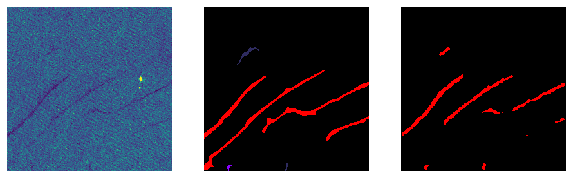

mask:
classes: [0 1 3]
counts: [65037   282   217]
pred:
classes: [0]
counts: [65536]


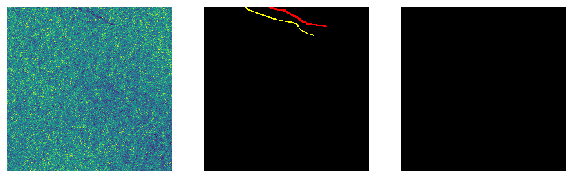

In [40]:
#Load current best model
model.load_state_dict(torch.load('current_best_model_state_dict.pth'))

# Preview images masks and predictions from validation set
images, masks = next(iter(dataloader_val))

images = images.to(device)
model.eval()
torch.set_grad_enabled(False)
preds = model(images.float())

images = images.data.cpu().numpy()
masks = masks.data.cpu().numpy()
preds = preds.data.cpu().numpy()

#print(images.shape, masks.shape, preds.shape)

for i in range(images.shape[0]):
    image = images[i,:,:,:]
    mask = masks[i,:,:,:]
    pred = preds[i,:,:,:]
    
    image = np.squeeze(image)
    mask = np.squeeze(mask)
    pred = np.squeeze(pred)   
    
    image = inv_normalize(image)       
        
    mask = onehot2mask(mask)
    print('mask:')
    distr(mask)
    
    pred = np.where(pred>0.5,1,0)
    pred = onehot2mask(pred)
    print('pred:')
    distr(pred)

    preview((image, mask2p(mask), mask2p(pred)))